## **Chest X-ray classification between Covid, pneumonia, normal using GoogleNet**

+ **About**: 
    + This notebook contains code to run experiments for paper: Covid-19 Chest X-ray classification and severity assessment using Convolutional and Transformer Neural Networks 

+ **Datasets**:
    + The COVID CXR dataset
    + The Chest Xray Pneumonia dataset 


+ **Classes**: 
    + Normal
    + Pneumonia
    + Covid_19

+ **Architecture**: 
    + GoogLeNet



In [1]:
import os
import cv2
import platform
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

os.environ['PYTHONHASHSEED'] = '73'

seed = 73
random.seed(seed)
np.random.seed(seed)

print(platform.platform())
%matplotlib inline

Windows-10-10.0.19043-SP0


In [2]:
three_classes_covid_xray_balanced = "/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-cxr2/datasets/severity_dataset/joined_RALO_Brook/train"

In [3]:
print('> train_covidx9a_balance_9449 dir:', os.listdir(three_classes_covid_xray_balanced))

> train_covidx9a_balance_9449 dir: ['level1', 'level2']


## **Data Preparation**

### Read train_df

In [4]:
from tqdm import tqdm

train_image_dir = three_classes_covid_xray_balanced 
img_map = []

def prepareData(Dir, strat):
    cats = ["level1","level2"]
    for category in cats:
        path = os.path.join(Dir,category)
        class_num = cats.index(category)
        
        for img in tqdm(os.listdir(path)):
            img_path = os.path.join(path,img)
            img_map.append({'path': img_path, 'label': category})

prepareData(train_image_dir,'train')
img_map_covidx9a = pd.DataFrame(img_map).sample(frac = 1, random_state=seed)

100%|██████████| 1901/1901 [00:00<00:00, 316692.69it/s]


In [5]:
img_map_covidx9a.head()

,path,label
2402,/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...,level2
418,/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...,level1
1516,/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...,level2
106,/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...,level1
441,/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...,level1


### Read test_df

In [6]:
from tqdm import tqdm

test_image_dir = "/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-cxr2/datasets/severity_dataset/joined_RALO_Brook/test/"

img_map = []

def prepareData(Dir, strat):
    cats = ["level1", "level2"]
    for category in cats:
        path = os.path.join(Dir,category)
        class_num = cats.index(category)
        
        for img in tqdm(os.listdir(path)):
            img_path = os.path.join(path,img)
            img_map.append({'path': img_path, 'label': category})

prepareData(test_image_dir,'train')
test_img_map_covidx9a = pd.DataFrame(img_map).sample(frac = 1, random_state=seed)

100%|██████████| 98/98 [00:00<00:00, 97937.05it/s]


### Images Visualization

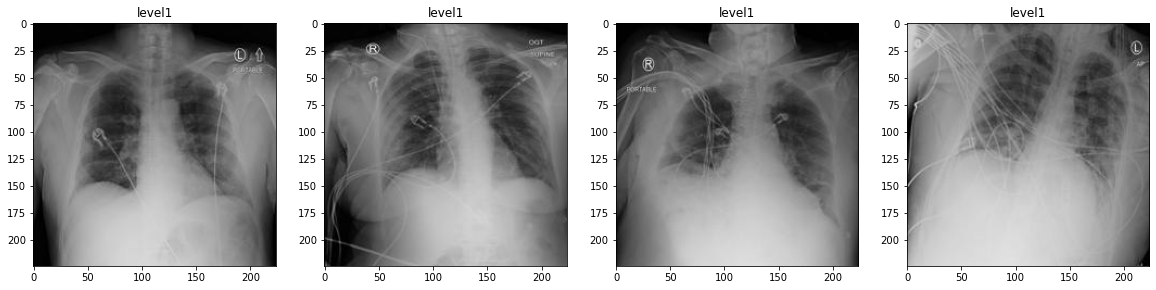

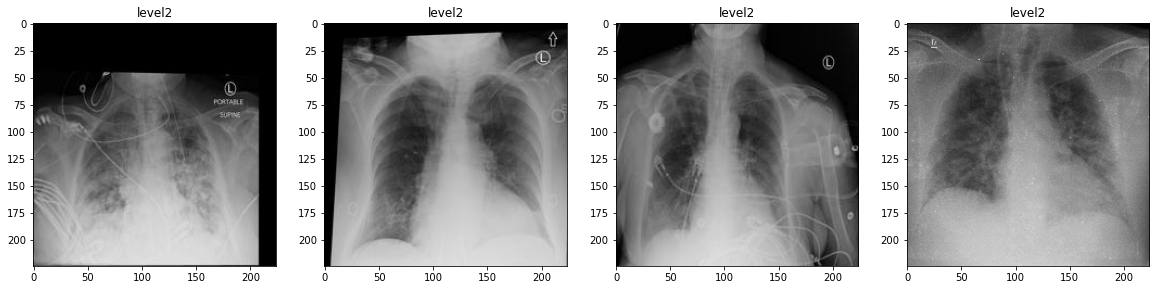

In [7]:
import matplotlib.pyplot as plt

def print_images(samples): 
    images = samples["path"].to_numpy()
    labels = samples['label'].to_numpy()
    
    fig=plt.figure(figsize=(20, 8))
    columns = 4
    rows = 1
    
    for i, image_path in enumerate(images):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        fig.add_subplot(rows,columns,i + 1)
        title = '{}'.format(labels[i])
        
        Sample_image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_CUBIC)
        
        plt.imshow(Sample_image, cmap='gray')
        plt.title(title)
        
    plt.show()
        
print_images(img_map_covidx9a[img_map_covidx9a['label']=="level1"].iloc[0:4])
print_images(img_map_covidx9a[img_map_covidx9a['label']=="level2"].iloc[0:4])
#print_images(img_map_covidx9a[img_map_covidx9a['label']=="COVID-19"].iloc[0:4])

%matplotlib inline

In [8]:
def getLabelCount(frame):
    label_count = pd.Series(frame['label'].values.ravel()).value_counts()
    n_classes = (label_count)
    return label_count

label_count = getLabelCount(img_map_covidx9a)
print(label_count)

level2    1901
level1    1231
dtype: int64


In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

features = img_map_covidx9a['path'].to_numpy()
labels = img_map_covidx9a['label'].to_numpy()

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=73)

In [10]:
for train_index, val_index in stratified_sample.split(features, labels):
    X_train, val_X = features[train_index], features[val_index]
    y_train, val_y = labels[train_index], labels[val_index]
    
half_size = np.int(len(val_X))
X_val, y_val = val_X[0:half_size], val_y[0:half_size]

C:\Users\MCSP_Lab\AppData\Local\Temp/ipykernel_21768/2451442638.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  half_size = np.int(len(val_X))


In [11]:
train_map = pd.DataFrame()
train_map['path'], train_map['label'] = X_train, y_train

In [12]:
val_map = pd.DataFrame()
val_map['path'], val_map['label'] = X_val, y_val

In [13]:
# data summary
print('> {} train size'.format(X_train.shape[0]))
print('> {} val size'.format(X_val.shape[0]))

> 2505 train size
> 627 val size


In [14]:
train_map.head()

,path,label
0,/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...,level1
1,/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...,level1
2,/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...,level2
3,/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...,level1
4,/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...,level1


### Data Augmentation

In [15]:
import cv2
import time
import imageio
import imgaug.augmenters as iaa
import imgaug as ia
ia.seed(73)

ColorCh = 3
#IMG_SIZE = 224
IMG_SIZE = 224
input_shape=(IMG_SIZE, IMG_SIZE, ColorCh)

classes = ("level1", "level2")
CATEGORIES = sorted(classes)

print('> Classes:',CATEGORIES)

> Classes: ['level1', 'level2']


In [16]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

datagen = ImageDataGenerator(rescale = 1./255, 
                             horizontal_flip=True,
                             brightness_range=[1.0,1.3],
                             rotation_range=15,
                             #zoom_range=0.2
                            )

In [17]:
batch_size = 8

def get_generator(frame_):
    generator = datagen.flow_from_dataframe(
                          dataframe=frame_,
                          x_col="path",
                          y_col="label",
                          batch_size=batch_size,
                          seed=seed,
                          shuffle=False,
                          class_mode="sparse",
                          color_mode="rgb",
                          save_format="jpeg",
                          target_size=(IMG_SIZE,IMG_SIZE)             
             )
    
    return generator

### Get train_generator

In [18]:
train_df = train_map.sample(frac=1, random_state=seed)
train_generator = get_generator(train_df)

print('> label count for train set')
getLabelCount(train_df)

Found 2505 validated image filenames belonging to 2 classes.
> label count for train set


level2    1520
level1     985
dtype: int64

In [19]:
val_df = val_map.sample(frac=1, random_state=seed)
val_generator = get_generator(val_df)

print('> label count for val set')
getLabelCount(val_df)

Found 627 validated image filenames belonging to 2 classes.
> label count for val set


level2    381
level1    246
dtype: int64

In [20]:
test_generator = get_generator(test_img_map_covidx9a)

print('> label count for test set')
getLabelCount(test_img_map_covidx9a)

Found 150 validated image filenames belonging to 2 classes.
> label count for test set


level2    98
level1    52
dtype: int64

In [21]:
print('> input shape:', input_shape)

> input shape: (224, 224, 3)


## **Model Construction**

In [22]:
import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Add, add
from tensorflow.keras.layers import InputLayer, Input, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Activation, MaxPool2D, ZeroPadding2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from keras import regularizers

kernel_regularizer = regularizers.l2(0.0001)

final_activation = 'softmax'
entropy = 'sparse_categorical_crossentropy'
n_classes = len(CATEGORIES)
print('> {} classes'.format(n_classes))

> 2 classes


In [23]:
def FCLayers(baseModel):
    baseModel.trainable = True
    headModel = baseModel.output
    headModel = Dropout(0.5, seed=73)(headModel)
    headModel = Dense(n_classes, activation=final_activation)(headModel)
    
    model = Model(inputs = baseModel.input, outputs = headModel)
    return model

### Build GoogleNet

In [24]:
from keras.layers.merge import concatenate

def Inception_block(input_layer, f1, f2, f3, f4):    
    
    path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    
    path2 = Conv2D(filters = f2[0], kernel_size = (1,1), 
                   padding = 'same', activation = 'relu')(input_layer)
    
    path2 = Conv2D(filters = f2[1], kernel_size = (3,3), 
                   padding = 'same', activation = 'relu')(path2)

    path3 = Conv2D(filters = f3[0], kernel_size = (1,1), 
                   padding = 'same', activation = 'relu')(input_layer)
    
    path3 = Conv2D(filters = f3[1], kernel_size = (5,5), 
                   padding = 'same', activation = 'relu')(path3)

    path4 = MaxPooling2D((3,3), strides= (1,1), 
                         padding = 'same')(input_layer)
    
    path4 = Conv2D(filters = f4, kernel_size = (1,1), 
                   padding = 'same', activation = 'relu')(path4)
    
    output_layer = concatenate([path1, path2, path3, path4], axis = -1)

    return output_layer

In [25]:

def Extra_network_2(X):
    X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X2 = Conv2D(filters = 128, kernel_size = (1,1), 
                padding = 'same', activation = 'relu')(X2)
    
    X2 = Flatten()(X2)
    X2 = Dense(1024, activation = 'relu')(X2)
    X2 = Dropout(0.5)(X2)
    X2 = Dense(n_classes, activation = final_activation, name="output2")(X2)
    return X2


def Extra_network_1(X):
    X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X1 = Conv2D(filters = 128, kernel_size = (1,1), 
                padding = 'same', activation = 'relu')(X1)
    
    X1 = Flatten()(X1)
    X1 = Dense(1024, activation = 'relu')(X1)
    X1 = Dropout(0.5)(X1)
    X1 = Dense(n_classes, activation = final_activation, name="output1")(X1)
    return X1

In [26]:
def layer_4(X):
    X = Inception_block(X, 192, (96, 208) , (16, 48), 64)
    
    X1 = Extra_network_1(X)
    
    X = Inception_block(X, 160, (112, 224), (24, 64), 64)
    X = Inception_block(X, 128, (128, 256), (24, 64), 64)
    X = Inception_block(X, 112, (144, 288), (32, 64), 64)
    
    X2 = Extra_network_2(X)
    
    X = Inception_block(X, 256, (160, 320), (32, 128), 128)
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)
    
    return X, X1, X2

def layer_3(X):
    X = Inception_block(X, 64, (96, 128), (16, 32), 32)
    X = Inception_block(X, 128, (128, 192), (32, 96), 64)
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)
    
    return X

def layer_2(X):
    X = Conv2D(filters = 64, 
               kernel_size = 1, 
               strides = 1, 
               padding = 'same', 
               activation = 'relu')(X)
    
    X = Conv2D(filters = 192, 
               kernel_size = 3, 
               padding = 'same', 
               activation = 'relu')(X)
    
    X = MaxPooling2D(pool_size= 3, strides = 2)(X)
    
    return X

In [27]:
def load_GoogLeNet():
    input_layer = Input(shape = input_shape)
    
    X = Conv2D(64, kernel_size = 7, strides = 2, 
               padding = 'valid', activation = 'relu')(input_layer)
    
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)
    
    X = layer_2(X)
    X = layer_3(X)
    X, X1, X2 = layer_4(X)

    X = Inception_block(X, 256, (160, 320), (32, 128), 128)
    X = Inception_block(X, 384, (192, 384), (48, 128), 128)

    X = GlobalAveragePooling2D()(X)
    X = Dropout(0.6)(X)
    
    X = Dense(n_classes, activation = final_activation, name="output3")(X)
  
    model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

    return model

load_GoogLeNet().summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 109, 109, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 54, 54, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 54, 54, 64)   4160        max_pooling2d[0][0]              
__________________________________________________________________________________________

### Get metrics

In [28]:
def getMetrics(name, type_):
    if name == 'GoogLeNet':
        if type_ == 'accuracy':
            return 'output3_accuracy'
        if type_ == 'loss':
            return 'output3_loss'
        if type_ == 'val_accuracy':
            return 'val_output3_accuracy'
        if type_ == 'val_loss':
            return 'val_output3_loss'
        
    else:
        if type_ == 'accuracy':
            return 'accuracy'
        if type_ == 'loss':
            return 'loss'
        if type_ == 'val_accuracy':
            return 'val_accuracy'
        if type_ == 'val_loss':
            return 'val_loss'

## **Setting Call Backs**

In [29]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
          
EPOCHS = 120
patience = 10

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8
        
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        
def getCallbacks(name):
    class myCallback(Callback):
        def on_epoch_end(self, epoch, logs={}):
            if ((logs.get(getMetrics(name,'accuracy'))>=0.999)):
                print("\nLimits Reached cancelling training!")
                self.model.stop_training = True

            
    end_callback = myCallback()

    lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

    lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

    early_stopping = EarlyStopping(patience = patience, monitor=getMetrics(name, 'val_loss'),
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)


    checkpoint_filepath = name + '_Weights.h5'

    model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor=getMetrics(name, 'val_loss'),
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)

    import datetime
    log_dir="logs/fit/" + '_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  
    tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

    return [end_callback, 
             lr_callback, 
             model_checkpoints,
             early_stopping,
             #tensorboard_callback,
             lr_plat
            ]

GoogLeNet_callbacks = getCallbacks('GoogLeNet')
SwinTransformer_callbacks = getCallbacks('SwinTransformer')
callbacks = getCallbacks('DenseNet121')
Hybrid_callbacks = getCallbacks('HybridTransformer') 
InceptionNet_callbacks = getCallbacks('InceptionNet')
DOLG_callbacks = getCallbacks('DOLGNet')

## **Compile Model**

In [30]:
from tensorflow_addons import optimizers as tfa_optimizers

def CompileModel(name, model):
    if name == 'GoogLeNet':
        model.compile(optimizer='adam', loss=entropy, metrics={"output1":"accuracy", "output2":"accuracy", "output3":"accuracy"})
    else:
        model.compile(optimizer='adam', loss=entropy, metrics=["accuracy"])
    return model

def FitModel(model, name):
    callbacks_ = callbacks
    if name == 'SwinTransformer':
        callbacks_ = SwinTransformer_callbacks
    if name == 'GoogLeNet':
        callbacks_ = GoogLeNet_callbacks
    if name == 'HybridTransformer':
        callbacks_ = Hybrid_callbacks
    if name == 'InceptionNet':
        callbacks_ = InceptionNet_callbacks
    if name == 'DOLGNet':
        callbacks_ = DOLG_callbacks
    history = model.fit(train_generator, 
                        epochs=EPOCHS,
                        callbacks=callbacks_,
                        validation_data = val_generator,
                        steps_per_epoch=(len(train_generator.labels) / 80),
                        validation_steps=(len(val_generator.labels) / 80),
                       )
    
    model.load_weights(name + '_Weights.h5')

    final_accuracy_avg = np.mean(history.history[getMetrics(name, "val_accuracy")][-5:])

    final_loss = history.history[getMetrics(name, "val_loss")][-1]
  
    group = {history: 'history', name: 'name', model: 'model', final_accuracy_avg:'acc', final_loss: 'loss'}

    print('\n')
    print('---'*15)
    print(name,' Model')
    print('Total Epochs :', len(history.history[getMetrics(name, 'loss')]))    
    print('Restoring best Weights')
    
    index = (len(history.history[getMetrics(name, 'loss')]) - (patience + 1))
    print('---'*15)
    print('Best Epoch :', index)
    print('---'*15)
    
    train_accuracy = history.history[getMetrics(name, 'accuracy')][index]
    train_loss = history.history[getMetrics(name, 'loss')][index]
    
    val_accuracy = history.history[getMetrics(name, 'val_accuracy')][index]
    val_loss = history.history[getMetrics(name, 'val_loss')][index]

    print('Accuracy on train:', train_accuracy,
          '\tLoss on train:', train_loss)
    
    print('Accuracy on val:', val_accuracy ,
          '\tLoss on val:', val_loss)
    print('---'*15)

    return model, history

In [31]:
def BuildModel(name):
    if name == 'GoogLeNet':
        prepared_model = load_GoogLeNet() 
    if name == 'DenseNet121':
        prepared_model = load_DenseNet121()
    if name == 'SwinTransformer':
        prepared_model = load_swin_transformer()
    if name == 'HybridTransformer':
        prepared_model = load_hybrid_swin_transformer()
    if name == 'InceptionNet':
        prepared_model = load_inception_net()
    if name == 'DOLGNet':
        prepared_model = load_DOLG_net()
    compiled_model = CompileModel(name, prepared_model)
    return compiled_model

## **Training GoogLeNet**

In [38]:
g_compiled_model = BuildModel('GoogLeNet')
g_model, g_history = FitModel(g_compiled_model, 'GoogLeNet')

Epoch 1/120
31/31 [==============================] - 13s 313ms/step - loss: 2.0782 - output3_loss: 0.6931 - output1_loss: 0.6929 - output2_loss: 0.6922 - output3_accuracy: 0.5117 - output1_accuracy: 0.5195 - output2_accuracy: 0.5859 - val_loss: 2.0771 - val_output3_loss: 0.6927 - val_output1_loss: 0.6920 - val_output2_loss: 0.6924 - val_output3_accuracy: 0.5469 - val_output1_accuracy: 0.5469 - val_output2_accuracy: 0.5469

Epoch 00001: val_output3_loss did not improve from 0.57167
Epoch 2/120
31/31 [==============================] - 9s 274ms/step - loss: 2.0715 - output3_loss: 0.6916 - output1_loss: 0.6897 - output2_loss: 0.6902 - output3_accuracy: 0.5820 - output1_accuracy: 0.5859 - output2_accuracy: 0.5859 - val_loss: 2.0741 - val_output3_loss: 0.6913 - val_output1_loss: 0.6917 - val_output2_loss: 0.6911 - val_output3_accuracy: 0.5469 - val_output1_accuracy: 0.5469 - val_output2_accuracy: 0.5469

Epoch 00002: val_output3_loss did not improve from 0.57167
Epoch 3/120
31/31 [==========

## **Model Evaluation on the TestSet**

In [33]:
%matplotlib inline
def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)

In [34]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, accuracy_score, classification_report, confusion_matrix

def test_set_results(pred_value, n=1):    
    y_test = test_generator.labels
    X_test, _ = test_generator.next()
    
    corr_pred = metrics.confusion_matrix(y_test, pred_value)
    fig=plt.figure(figsize=(10, 8))
    ax = plt.axes()
    
    sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Purples", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
    ax.set_title('Dense Output {}'.format(n))
    plt.show()
    
    n_correct = np.int(corr_pred[0][0] + corr_pred[1][1]) # + corr_pred[2][2]
    print('...'*15)

    print('> Correct Predictions:', n_correct)
    
    n_wrongs = len(y_test) - n_correct
    print('> Wrong Predictions:', n_wrongs)
    print('...'*15)
    
    print(classification_report(test_generator.labels, pred_value, target_names=CATEGORIES))

In [35]:
def printResults(name, model):
    predictions = model.predict(test_generator, verbose=1)
    preds = np.argmax(predictions, axis=1)
    test_set_results(preds)

In [36]:
def model_summary(model, history, name):
    index = (len(history.history[getMetrics(name, 'loss')]) - (patience + 1))
    print('Best Epochs: ', index)
    
    if name == 'GoogLeNet':
        results = model.evaluate(test_generator, verbose=1)
        loss, output3_loss, output1_loss, output2_loss, output3_accuracy, output1_accuracy, output2_accuracy = results
        
        for i in range(3):
            n = i + 1
            out_layer = 'Output Layer {}'.format(n)
            
            if n == 1:
                test_accuracy = output1_accuracy
                test_loss = output1_loss

            if n == 2:
                test_accuracy = output2_accuracy
                test_loss = output2_loss
                
            if n == 3:
                test_accuracy = output3_accuracy
                test_loss = output3_loss
                
                
            output_name = 'output{}_'.format(n)
            train_accuracy, train_loss = history.history[output_name + 'accuracy'][index], history.history[output_name + 'loss'][index]
            
  
            print_graph(output_name + 'loss', index, history)
            print_graph(output_name + 'accuracy', index, history)
        
            print('---'*15)  
            print('GoogLeNet Dense output {}:'.format(n))
            
            print('> Accuracy on train :'.format(out_layer), train_accuracy, 
                  '\tLoss on train:',train_loss)
        
            print('> Accuracy on test :'.format(out_layer), test_accuracy,
                  '\tLoss on test:',test_loss)
            
            print('---'*15)
            print('> predicting test')
            print('---'*15)
            
            predictions = model.predict(test_generator, verbose=1)
            preds = np.argmax(predictions[i], axis=1)
            test_set_results(preds, n)
                
    else:
        test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
        
        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        
        print('---'*15) 
        print(name)
        print('> Accuracy on train:',train_accuracy, 
              '\tLoss on train:',train_loss)
        
        print('> Accuracy on test:',test_accuracy,
              '\tLoss on test:',test_loss)
        
        print('---'*15)
        print('> predicting test')
        print('---'*15)
        
        printResults(name, model)

## **GoogLeNet Results**

Best Epochs:  26
19/19 [==============================] - 12s 652ms/step - loss: 1.8817 - output3_loss: 0.6356 - output1_loss: 0.6305 - output2_loss: 0.6157 - output3_accuracy: 0.6733 - output1_accuracy: 0.6667 - output2_accuracy: 0.6733


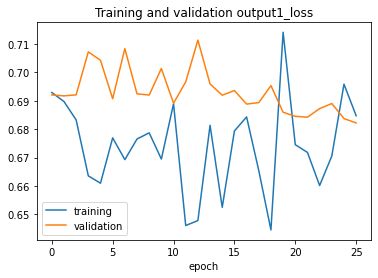

<Figure size 432x288 with 0 Axes>

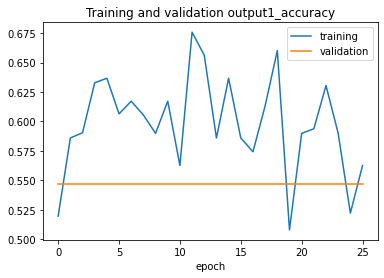

---------------------------------------------
GoogLeNet Dense output 1:
> Accuracy on train : 0.5783132314682007 	Loss on train: 0.6777465343475342
> Accuracy on test : 0.6666666865348816 	Loss on test: 0.6304897665977478
---------------------------------------------
> predicting test
---------------------------------------------
19/19 [==============================] - 13s 677ms/step


<Figure size 432x288 with 0 Axes>

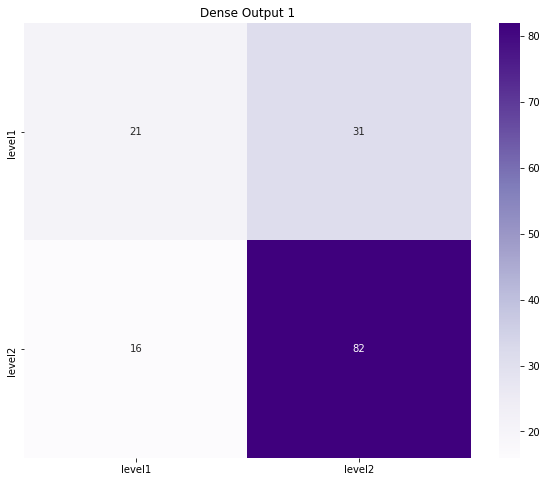

.............................................
> Correct Predictions: 103
> Wrong Predictions: 47
.............................................
              precision    recall  f1-score   support

      level1       0.57      0.40      0.47        52
      level2       0.73      0.84      0.78        98

    accuracy                           0.69       150
   macro avg       0.65      0.62      0.62       150
weighted avg       0.67      0.69      0.67       150



C:\Users\MCSP_Lab\AppData\Local\Temp/ipykernel_21768/3032867848.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int(corr_pred[0][0] + corr_pred[1][1]) # + corr_pred[2][2]


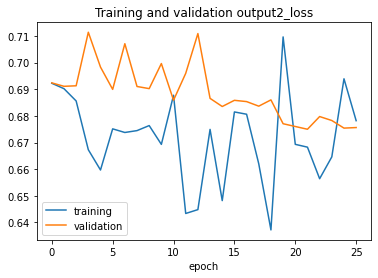

<Figure size 432x288 with 0 Axes>

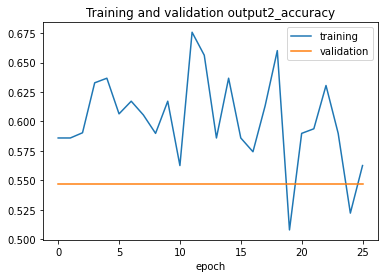

---------------------------------------------
GoogLeNet Dense output 2:
> Accuracy on train : 0.5783132314682007 	Loss on train: 0.6735599637031555
> Accuracy on test : 0.6733333468437195 	Loss on test: 0.6156719923019409
---------------------------------------------
> predicting test
---------------------------------------------
19/19 [==============================] - 12s 638ms/step


<Figure size 432x288 with 0 Axes>

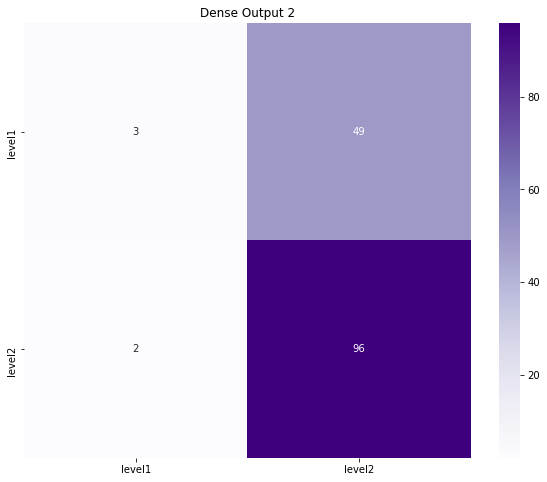

.............................................
> Correct Predictions: 99
> Wrong Predictions: 51
.............................................
              precision    recall  f1-score   support

      level1       0.60      0.06      0.11        52
      level2       0.66      0.98      0.79        98

    accuracy                           0.66       150
   macro avg       0.63      0.52      0.45       150
weighted avg       0.64      0.66      0.55       150



C:\Users\MCSP_Lab\AppData\Local\Temp/ipykernel_21768/3032867848.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int(corr_pred[0][0] + corr_pred[1][1]) # + corr_pred[2][2]


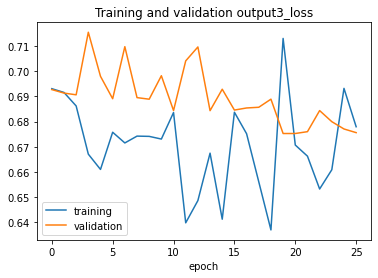

<Figure size 432x288 with 0 Axes>

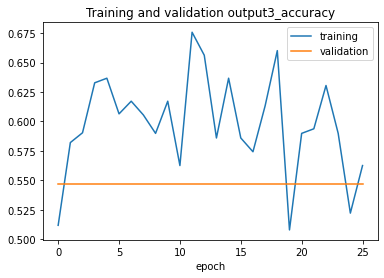

---------------------------------------------
GoogLeNet Dense output 3:
> Accuracy on train : 0.5783132314682007 	Loss on train: 0.6728940010070801
> Accuracy on test : 0.6733333468437195 	Loss on test: 0.6355785131454468
---------------------------------------------
> predicting test
---------------------------------------------
19/19 [==============================] - 13s 678ms/step


<Figure size 432x288 with 0 Axes>

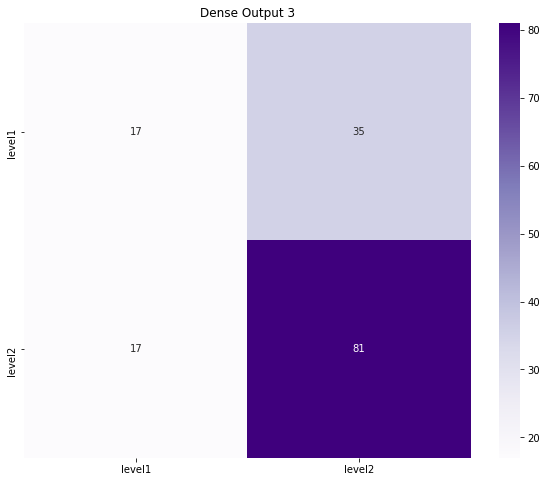

.............................................
> Correct Predictions: 98
> Wrong Predictions: 52
.............................................
              precision    recall  f1-score   support

      level1       0.50      0.33      0.40        52
      level2       0.70      0.83      0.76        98

    accuracy                           0.65       150
   macro avg       0.60      0.58      0.58       150
weighted avg       0.63      0.65      0.63       150



C:\Users\MCSP_Lab\AppData\Local\Temp/ipykernel_21768/3032867848.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int(corr_pred[0][0] + corr_pred[1][1]) # + corr_pred[2][2]


In [39]:
model_summary(g_model, g_history, 'GoogLeNet')